Copyrights goes to oussmasmihrou@centrale-casablanca.ma

In [1]:
import re
import os
import csv
import json
import nltk
import time
import spacy 
import shutil
import logging
import requests
import matplotlib
import numpy as np
import random as rd
import pandas as pd
import urllib.request
from PIL import Image
import networkx as nx
from spacy import displacy
from tqdm.notebook import *
import plotly.express as px
from bs4 import BeautifulSoup
from itertools import groupby
from spacy.tokens import Span 
from selenium import webdriver
import matplotlib.pyplot as plt
from newsapi import NewsApiClient
from spacy.matcher import Matcher 
from urllib.request import urlopen
from typing import List, Tuple, Dict
from matplotlib.pyplot import figure
from nltk.tag import StanfordNERTagger
from nltk.tokenize import word_tokenize
from stanfordcorenlp import StanfordCoreNLP
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.firefox.options import Options as FirefoxOptions

# I- Fetching data :

Used to fetch news data using an original scrapper, so they be injected into the model as additional features  

In [4]:
def scrap_one_article(url, _, nbr_articles) -> Dict:
    
    #Function that scrapps one article's data and zipps it into a dictionary 
    url_clean = url
    if url[6:19] == url[26:39]:
        url_clean = url[19:]
        print(url_clean)
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'lxml')
    author = 'BBC News'
    title = None
    
    #Certain articles do miss some elements, they are rare. 
    try:
        author = soup.find_all(class_ = 'ssrcss-1rv0moy-Contributor')[0].find('strong').text[3:]
    except:
        pass
    try:
        title = soup.find_all(class_ = 'ssrcss-gcq6xq-StyledHeading')[0].text
    except: 
        pass
    try:
        date = soup.find_all(class_ = 'ecn1o5v2')[0].find('time')['datetime'][:10]
    except: 
        date = None
    try:
        cathegory = soup.find_all(class_ = 'ed0g1kj0')[0].text
    except: 
        cathegory = 'General'
    Content_list = soup.find_all(class_ = 'eq5iqo00')
    article_content = build_text(Content_list)
    try:
        article_content = article_content.strip('There\'s something for everyone on iPlayer\nIncluding Frozen, Moana, Worzel Gummidge and more...','')
        article_content = article_content.strip('If you are reading this page and can\'t see the form you will need to visit the mobile version of the BBC website to submit your question or comment or you can email us at HaveYourSay@bbc.co.uk. Please include your name, age and location with any submission','')
    except:
        pass
    if article_content[:28] == 'This video can not be played':
        article_content = article_content[29:]
    Images_descriptions = download_images_description(soup)    
    article_dic= {'url': url_clean,'author':author,'date': date,'cathegory':cathegory,'title':title,'article_content':article_content, 'Image count': len(Images_descriptions), 'images descriptions':Images_descriptions}
    return article_dic

In [3]:
#tools
def build_text(list_) -> str:
    
    #building a text from a list 
    list_.pop()
    return '\n'.join([x.text for x in list_])
def dl_img(url, file_path, file_name) -> str:
    full_path = file_path + file_name + '.jpg'
    urllib.request.urlretrieve(url, full_path)
    return full_path
def download_images(soup_result,article_index,nbr_articles) -> int:
    
    #Downloading images from a links lists, then storing them locally ( within the server if it was hosted )
    nbr_img = 0
    try:
        os.mkdir(f'images/Article{article_index}')
    except:
        pass
    img_results = [res['src'] for res in soup_result.find_all('img')][-12:]
    print(len(img_results))
    for _ in tqdm (range(1,len(img_results))):
        image_link = img_results[_]
        image_link_loc = f'images/Article{article_index}/'
        file_name = f'img{_}'
        try:
            image_link_local = dl_img(image_link,image_link_loc, file_name)
            i += 1
            nbr_img+=1
        except:
            pass
        return nbr_img
def download_images_description(soup_result) -> List:
    
    #Downloading description of images.
    nbr_img = 0
    try:
        os.mkdir(f'images/Article{article_index}')
    except:
        pass
    img_results = [res['alt'] for res in soup_result.find_all('img')][-12:]
    img_results
    return img_results

In [4]:
options = FirefoxOptions()
#options.add_argument("--headless")
driver = webdriver.Firefox(options=options)
driver.get("https://www.bbc.com/news/science-environment-56837908")
links = []
def get_links_list(driver,page) -> List[str]:
        
    '''Fetch all of the article's links from the BBC Climate url
       Selinium is used as well to scroll the News Updates pages'''
    if page > 49:
        return links
    else:
        while True:
            try:
                if driver.find_elements(By.CLASS_NAME,'qa-heading-link') != None:
                    for _ in driver.find_elements(By.CLASS_NAME,'qa-heading-link') :
                        links.append(_.get_attribute('href'))
                    break
            except:
                pass
        try:
                WebDriverWait(driver, 2500).until(EC.element_to_be_clickable((By.CSS_SELECTOR, ".qa-pagination-next-page[rel='next']"))).click()
        except:
                pass
        page = page+1
        return get_links_list(driver, page+1)
def get_links_update(url = 'https://www.bbc.com/news/science-environment-56837908'):
    
    #fetch latest articles links via beautiful soup
    url = 'https://www.bbc.com/news/science-environment-56837908'
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'lxml')
    results = soup.find_all('a',class_ = 'qa-heading-link')
    links_list = ['http://www.bbc.com/'+res['href'] if (res['href'][6:19] != res['href'][26:39]) else res['href'] for res in results]
    return links_list[:15]
links = get_links_list(driver,0)

In [5]:
#A tool function to scrap a category from links
def scrap_bbc_articles(links,category_url = 'https://www.bbc.com/news/science-environment-56837908') -> List[Dict]:
    
    # Scrap all of the articles
    url = category_url
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'lxml')
    print('Request status (200 means a succesful request): ',response.status_code)
    print('fetching begun ...')
    print('Fetching data from ',len(links) - 5 ,' bbc news articles')
    results = []
    print('------------------------------------')
    for _ in tqdm(range(0,len(links)-5), desc = 'Fetching articles'):  # Covers all the articles len(links)+1
        try: 
            A = scrap_one_article(links[_], _, len(links))
            results.append(A)
        except:
            _ = _ +1
    return results

In [6]:
# A fúnction used to scrap and zip articles information from a list of links
def scrap(links) -> List[Dict]:
    climate_url = 'https://www.bbc.com/news/science-environment-56837908'
    data = scrap_bbc_articles(links)
    # fetching data from articles
    article_results = [] 
    for i in range(len(data)):
        try:
                article_dict = {}
                article_dict['cathegory'] = data[i]['cathegory']
                article_dict['author'] = data[i]['author']
                article_dict['title'] = data[i]['title']
                article_dict['Publish date'] = data[i]['date']
                article_dict['url'] = data[i]['url']
                article_dict['article_content'] = data[i]['article_content'].strip("\n").strip("\t")
                article_dict['images descriptions'] = data[i]['images descriptions']
                article_results.append(article_dict)
        except IndexError:
                pass
    return article_results

In [7]:
def scrap_all():
    print('updating Data ...')
    # a function to update the articles Data Base
    url = 'https://www.bbc.com/news/science-environment-56837908'
    data = pd.DataFrame.from_dict(scrap(scrap_bbc_articles(get_links_list(driver,0)),get_links_list(driver,0)))
    print('Size of data : ', len(data))
    return data

In [6]:
pd.set_option('max_colwidth', 500)
pd.set_option('max_colwidth', 60)
def update_scrap():
    # Recover data from backup file
    Data = pd.read_csv('exported_bbc_data-labelised.csv')
    
    #Data.to_csv('exported_bbc_data-labelised.csv')
    #Data.to_csv('dash_web_app/exported_bbc_data-labelised.csv')
    print('updating Data ...')
    # a function to update the articles Data Base
    #data = pd.DataFrame.from_dict(scrap(all_links))
    #data = pd.DataFrame.from_dict(scrap(links))
    #print('Size of data : ', len(data))
    #Data  = data.append(Data)
    return Data
Data = update_scrap()
# Load from 
Data.head()

updating Data ...


Unnamed: 0                  cathegory        author  \
0           0             Climate change   Tom Espiner   
1           1             Our Planet Now      BBC News   
2           2  Tonga volcano and tsunami    athan Amos   
3           3             Climate change  Helen Briggs   
4           4             Climate change      BBC News   

                                                         title Publish date  \
0  Major investor will target bosses at firms failing on cl...   2022-01-23   
1          'Surreal' January wildfire shuts California highway   2022-01-22   
2               Tonga volcano: Plume reached half-way to space   2022-01-22   
3  False banana: Is Ethiopia's enset 'wondercrop' for clima...   2022-01-21   
4                New transport blueprint unveiled for Scotland   2022-01-20   

                                               article_content  \
0  A major UK investment fund has said it will vote to try ...   
1  An unseasonal wildfire is raging in California's Montere...   
2  An indicator of the great power of last Saturday's volca...   
3  Scientists say the plant enset, an Ethiopian staple, cou...   
4  A mass transit network in Glasgow and bridges or tunnels...   

                                           images descriptions  sentiment  
0  ['Deforestation', 'A composite image of a woman and a to...          2  
1  ['Colorado Fire burns down toward the Bixby Bridge in Bi...          1  
2  ['Presentational white space', 'A composite image of a w...          3  
3  ["Banner saying 'Get in touch'", 'A composite image of a...          1  
4  ['ScotRail train in countryside', 'A composite image of ...          2

In [9]:
Data.to_csv('dash_web_app/exported_bbc_data-labelised.csv')
Data.to_excel('dash_web_app/exported_bbc_data-labelised.xlsx')

<h1> II- Data preprocessing :</h1>

### 2.1 Introduction
Feature engineering is an important process in the pipeline of any machine learning project.
It involves applying a series of transformations to the data, including
data.
The motivation behind this process is to feed the algorithms with digested data
and to improve their performance by reducing the learning time.
In this project, different data processing techniques were applied to implement the NLP.

In [7]:
Data.columns

Index(['Unnamed: 0', 'cathegory', 'author', 'title', 'Publish date',
       'article_content', 'images descriptions', 'sentiment'],
      dtype='object')

In [8]:
def clean(Data,sentiment):
    useful_columns = ['cathegory', 'author', 'title', 'Publish date', 'article_content', 'images descriptions', 'sentiment' if sentiment == True else None, 'Named entities','NE summaries' ]
    for column in Data.columns:
        try:
            if not(column in useful_columns):
                Data = Data.drop(column, axis = 1)
            Data["Publish date"].fillna( method ='ffill', inplace = True) # Fill NaN values
            Data["title"].fillna('Title of article', inplace = True) # won't be used anyways
        except:
            pass
    
    return Data

Data = clean(Data,sentiment = True)
Data.to_csv('exported_bbc_data-labelised.csv')
Data.to_csv('dash_web_app/exported_bbc_data-labelised.csv')

Data.iloc[:20]

cathegory                        author  \
0              Climate change                   Tom Espiner   
1              Our Planet Now                      BBC News   
2   Tonga volcano and tsunami                    athan Amos   
3              Climate change                  Helen Briggs   
4              Climate change                      BBC News   
5              Climate change                      BBC News   
6              Climate change                 Louise Cullen   
7              Climate change  Beth Timmins & Daniel Thomas   
8              Climate change                      BBC News   
9              Climate change                    athan Amos   
10             Climate change                Suzanne Bearne   
11             Climate change                      BBC News   
12             Climate change                 Louise Cullen   
13             Climate change                      BBC News   
14             Climate change                      BBC News   
15             Climate change                  Sally Bowman   
16             Climate change                Roger Harrabin   
17             Climate change              Georgina Rannard   
18             Climate change                  Ruth Bradley   
19             Climate change             Steffan Messenger   

                                                          title Publish date  \
0   Major investor will target bosses at firms failing on cl...   2022-01-23   
1           'Surreal' January wildfire shuts California highway   2022-01-22   
2                Tonga volcano: Plume reached half-way to space   2022-01-22   
3   False banana: Is Ethiopia's enset 'wondercrop' for clima...   2022-01-21   
4                 New transport blueprint unveiled for Scotland   2022-01-20   
5   Liverpool Council funding airport at odds with climate a...   2022-01-20   
6       Stormont energy plan 'will create jobs and lower bills'   2022-01-20   
7   Inflation: Seven reasons the cost of living is going up ...   2022-01-20   
8    Cornwall's rockpool species 'threatened by climate change'   2022-01-20   
9             A68: 'Megaberg' dumped huge volume of fresh water   2022-01-20   
10            The people moving from high to low-carbon careers   2022-01-20   
11  Isle of Man ministers commit to review offshore energy s...   2022-01-19   
12     First NI environment strategy 'should be more ambitious'   2022-01-19   
13  Climate protesters call for ban on Manx fossil fuel extr...   2022-01-18   
14  Extinction Rebellion blasts Cornwall Council's 'hot air'...   2022-01-18   
15  Sustainable farming: Mum and daughter farmers take part ...   2022-01-18   
16          Government says its climate change curbs inadequate   2022-01-17   
17       Climate-related deaths fall in England and Wales - ONS   2022-01-17   
18  Energy bills: Thermal imaging used to help with cost of ...   2022-01-17   
19  Climate change: Wales has 'duty' due to coal mining history   2022-01-17   

                                                article_content  \
0   A major UK investment fund has said it will vote to try ...   
1   An unseasonal wildfire is raging in California's Montere...   
2   An indicator of the great power of last Saturday's volca...   
3   Scientists say the plant enset, an Ethiopian staple, cou...   
4   A mass transit network in Glasgow and bridges or tunnels...   
5   Liverpool's council must stop funding the city's airport...   
6   Northern Ireland's first energy strategy action plan has...   
7   From buying groceries to heating our homes, the cost of ...   
8   A study has found many rockpool species are threatened b...   
9   The monster iceberg A68 was dumping more than 1.5 billio...   
10  Watching the Red Arrows jet across the sky as a young bo...   
11  The Isle of Man's Council of Ministers has committed to ...   
12  More than 30 organisations and individuals have called f...   
13  A ban on extracting fossil fuels on the Isle of Man is n...   
14  Campai

### 2.3 NER : Named entities recognition :
Named entity recognition is a subtask of the activity of information extraction in documentary corpora. It consists of searching for textual objects (i.e. a word, or a group of words) that can be categorised in classes such as names of people, names of organisations or companies, names of places, quantities, distances, values, dates, etc.
As it is part of the task, we are asked to display sentiment analysis for each NER.
the aim of this sub-section is to try different Nlp models to get the list of named entities from text. the summaries of phrases in which they figured, as well as a google search for each entity, then store in the main output csv file.

In [9]:
index = 20
str_ = str(Data.iloc[index]['article_content']) # Article sample
str_

'Monday brings a big moment for Scotland\'s energy transition. Winners in the auction for 15 ScotWind sea areas will be announced.\nCovering 8,600 square kilometres, the announcement starts the process of a gigantic effort to put as many as 1,200 turbines out at sea. Many will be of the pioneering floating variety, giving us much more marine wind potential in deeper water.\nThey should, on average production, generate around twice the electricity Scotland needs, though that demand will rise as the nation transitions from carbon fuels to far more electricity use.\nFaith in that transition is being shaken by the exceptionally high costs for energy coming down the pipeline. Prices are already up. Household bills have been capped, and that cap is likely to rise by about 50% from April.\nThere\'s no way out of the rising bills. Ofgem, the regulator, is obliged by law to pass on the costs of sourcing energy.\nWe\'ll find out on 7 February just how high they are going to rise in spring, with 


#### 2.3.1 Spacy :

SpaCy is a Python software library for automatic language processing developed by Matt Honnibal and Ines Montani. SpaCy is open source software released under the MIT license. The SpaCy library can perform the following analysis operations on texts in over 50 languages : 
- Tokenization 
- NER


In [14]:
def get_Ner(str_) -> List[pd.DataFrame]:
    #using spacy to recognise named entites
    nlp = spacy.load("en_core_web_sm")
    doc = nlp(str_)
    entities = []
    labels = []
    position_start = []
    position_end = []
    for ent in doc.ents:
        entities.append(ent)
        labels.append(ent.label_)
        position_start.append(ent.start_char)
        position_end.append(ent.end_char)
    data_entities_2 = pd.DataFrame({'Entities':entities,'Labels':labels,'Position_Start':position_start, 'Position_End':position_end})
    persons_df = data_entities_2[['Entities','Labels']][(data_entities_2["Labels"] == 'PERSON')]
    country_df = data_entities_2[['Entities','Labels']][(data_entities_2["Labels"] == 'GPE')]
    org_df = data_entities_2[['Entities','Labels']][(data_entities_2["Labels"] == 'ORG')]
    return [data_entities_2,persons_df,country_df, org_df]

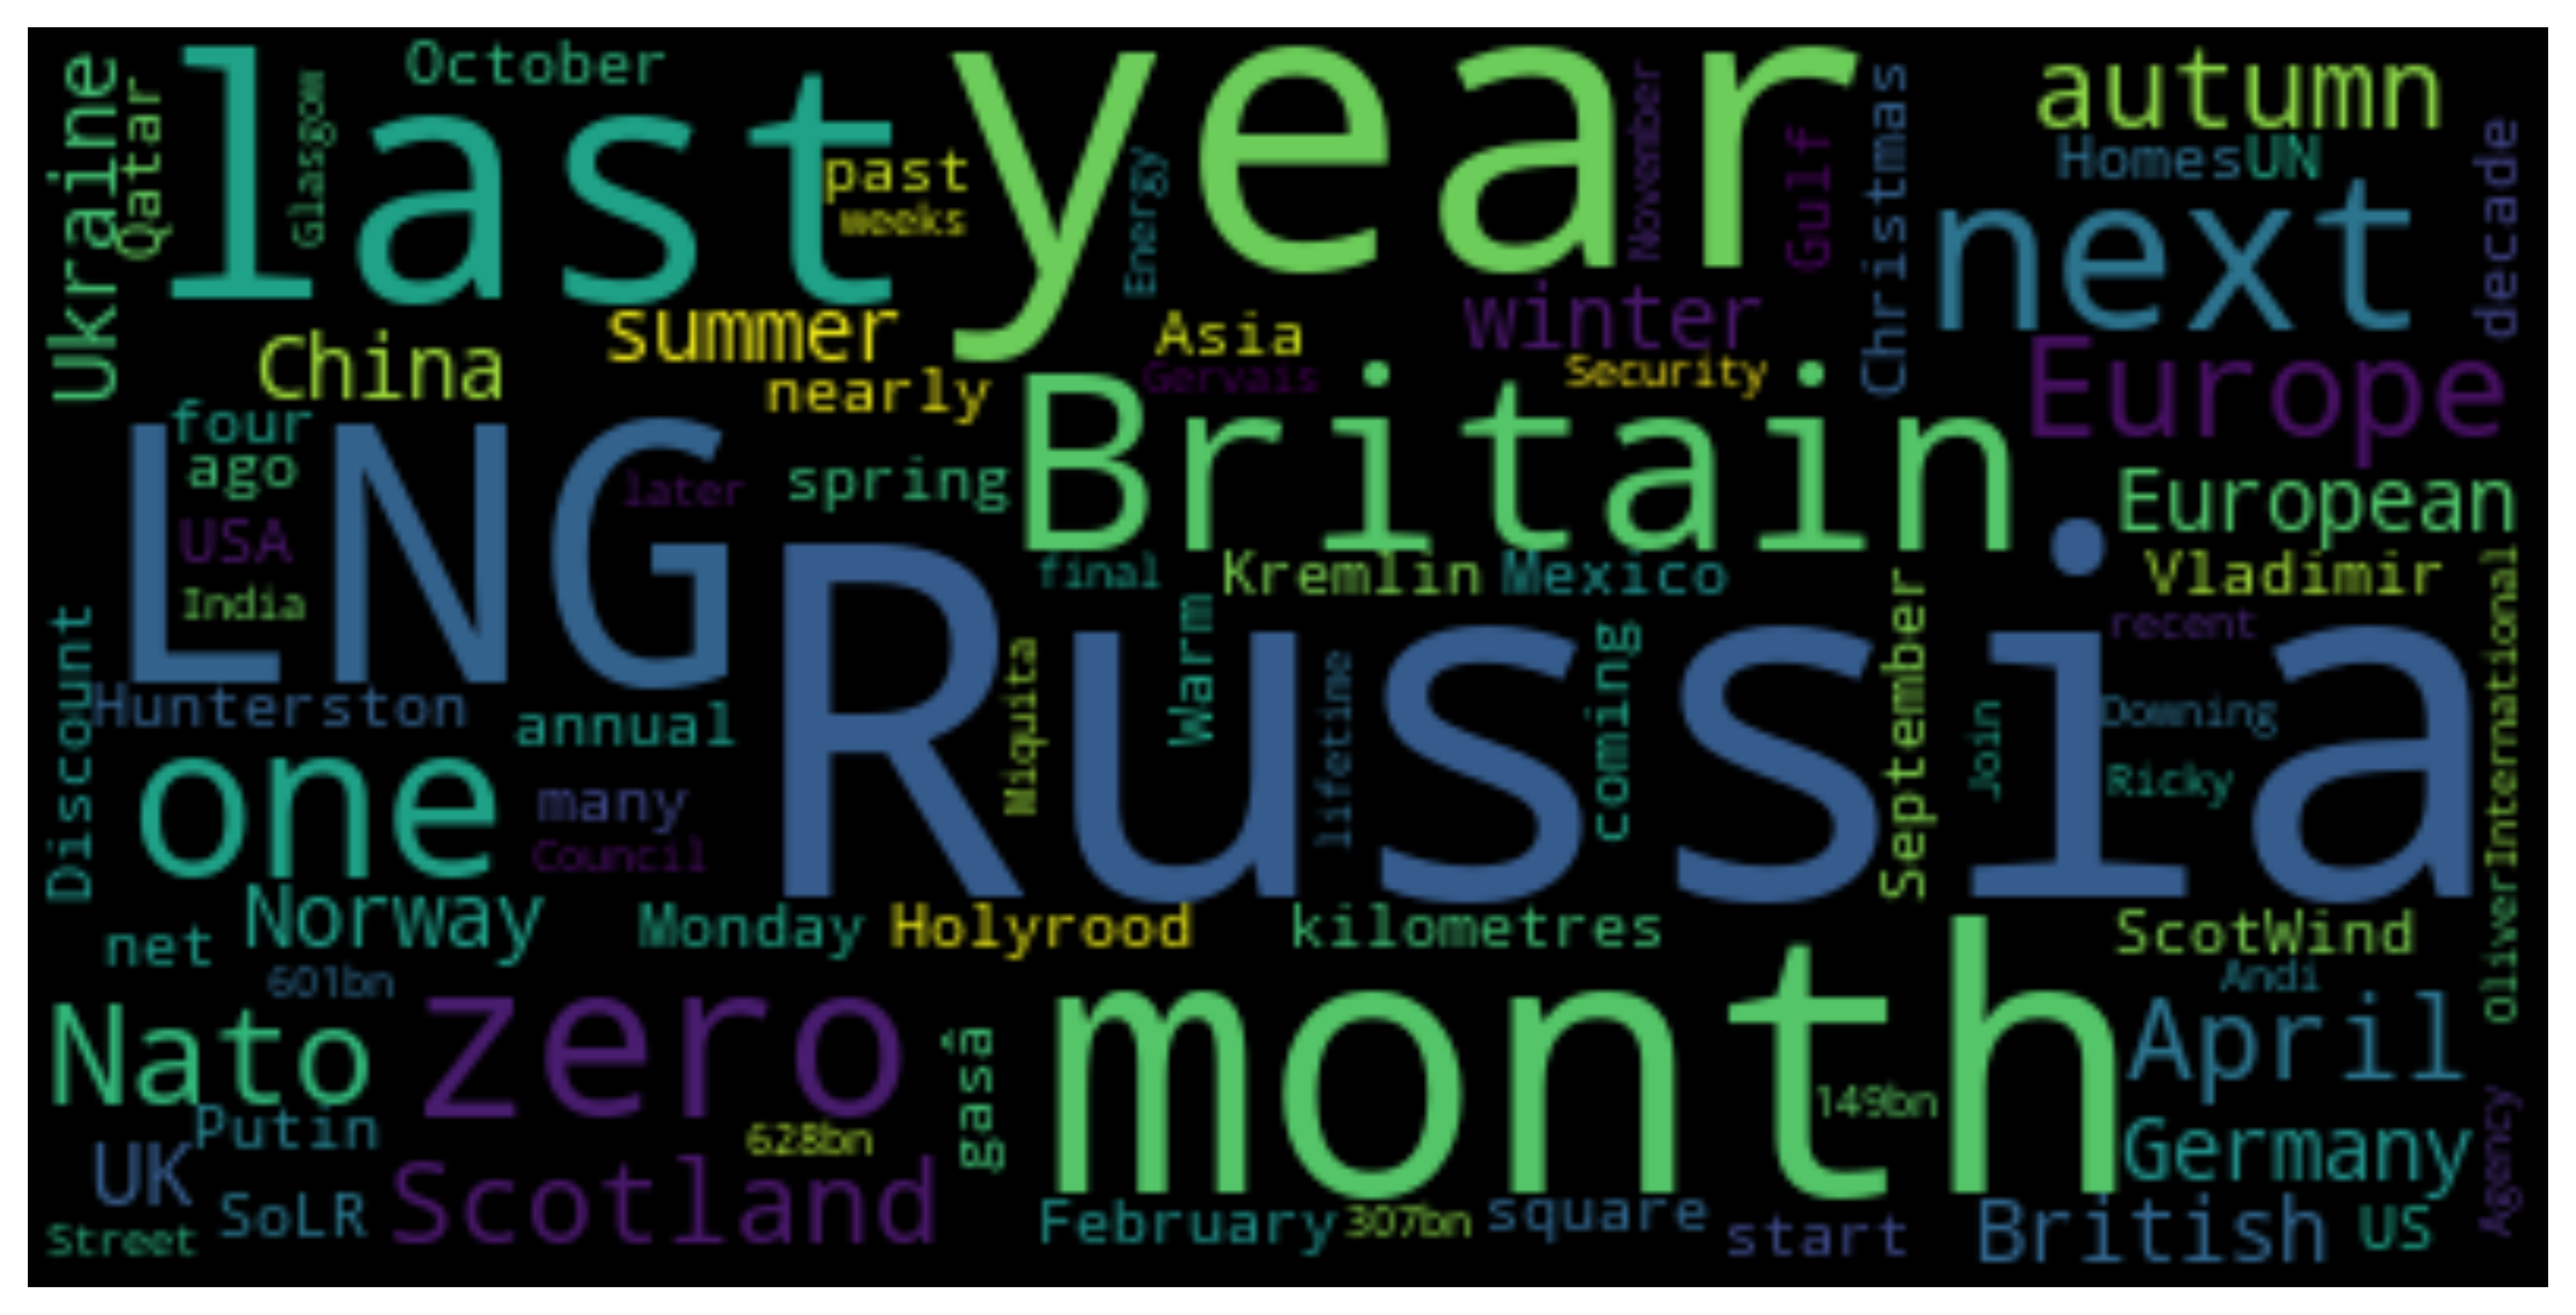

In [15]:
#Aranging named entites in a wordcloud
text = ' '.join([str(i) for i in get_Ner(str_)[0]['Entities'].to_list()])
wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(16, 6)
fig.set_dpi(500)
plt.show()

In [16]:
# fetch for results using a google api.
def NE_info_fetch(named_entity) -> str :
    url = "https://google-search26.p.rapidapi.com/search"
    Ne = named_entity
    querystring = {"q":Ne,"hl":"en","tbs":"qdr:a",'as_sitesearch':'wikipedia.com'}

    headers = {
        'x-rapidapi-host': "google-search26.p.rapidapi.com",
        'x-rapidapi-key': "ea42e2dcc0msh49ecba51860383ep18d94ejsnbb0488e12e70"
        }
    try:
        response = requests.request("GET", url, headers=headers, params=querystring)
        return (response.json()['results'][0]['snippet'][:300])
    except:
        return []
    
# get summary of two phrases ( topic sentence +1 ) in which the NER figured
def sumarize(List):
    result = []
    for _ in List:
        url = "https://api.meaningcloud.com/summarization-1.0"
        querystring = {"txt":_,"of":"json",'key':'1fe6342e2cfafb085d01802a50c98e6d','limit': 10}
        response = requests.request("GET", url, params=querystring)
        result.append(response.json()['summary'])
    return result

# get summary of phrases containning a certain named enitity
def get_summary(named_entity,index) -> List[str]:
    
    text = str(Data.iloc[index]['article_content'])
    phrases = nltk.tokenize.sent_tokenize(text)
    results = []
    for _ in range(len(phrases)):
        if named_entity in phrases[_]:
            results.append(phrases[_])
    return results

In [18]:
def ner_labelise(df) -> pd.DataFrame:
    ner_data = pd.DataFrame(columns = ['Named entities'])
    for _ in tqdm(range(len(df)), desc = 'NER'):
                try:
                    text = Data.iloc[_]['article_content']
                    Fetch_google = lambda x : NE_info_fetch(x) 
                    person_summaries = get_Ner(text)[1]['Entities'].map(lambda x : [get_summary(str(x),_), Fetch_google(str(x))])
                    countries_summaries = get_Ner(text)[2]['Entities'].map(lambda x : get_summary(str(x), _))
                    organisations_summaries = get_Ner(text)[3]['Entities'].map(lambda x : [get_summary(str(x), _),Fetch_google(str(x))])
                    persons = get_Ner(text)[1]['Entities'].tolist() , person_summaries.tolist()
                    countries = get_Ner(text)[2]['Entities'].tolist(), countries_summaries.tolist()
                    organisations = get_Ner(text)[3]['Entities'], countries_summaries.tolist()
                    list_ner_data =  {'persons':persons, 'countries': countries, 'organisations':organisations}
                    ner_data = ner_data.append({'Named entities' :list_ner_data},ignore_index = True)
                except:
                    pass
    df = df.reset_index(drop=True)
    ner_data = ner_data.reset_index(drop=True)
    return pd.concat([df,ner_data], axis = 1)
Labelised_ner_data = ner_labelise(Data)
Labelised_ner_data.to_csv('exported_bbc_data-labelised.csv')
Labelised_ner_data.to_csv('dash_web_app/exported_bbc_data-labelised.csv')
Labelised_ner_data.tail()

cathegory                           author  \
403           COP26                         BBC News   
404           COP26                     Bethan Lewis   
405  Climate change  Sabrina  Lee & Geraint Thomas     
406           COP26                         BBC News   
407           COP26                    David Shukman   

                                                           title Publish date  \
403  COP26: Scotland's young climate change activists in pict...   2021-11-02   
404  Climate change: New schools in Wales must be net zero fr...   2021-11-02   
405  COP26: Climate change graph 'needs more colours' as worl...   2021-11-02   
406       COP26: India PM Narendra Modi pledges net zero by 2070   2021-11-02   
407  COP26: What climate summit means for one woman in Bangla...   2021-11-02   

                                                 article_content  \
403  Thousands of activists and campaigners have converged on...   
404  New school and college buildings in Wales will have to m...   
405  The man behind a global warming stripe graphic said he's...   
406  India has promised to cut its emissions to net zero by 2...   
407  The people of Gabura in Bangladesh are having everything...   

                                             images descriptions  \
403  [Amelie, Laura Young, Nic Major, Sarra Wassu, Cammy Adai...   
404  [Around the BBC iPlayer footer, A composite image of a w...   
405  [Footer - Blue, A composite image of a woman and a towns...   
406  [Greta Thunberg addresses activists in Glasgow, A compos...   
407  [Gabura aerial shot, A composite image of a woman and a ...   

                                                  Named entities  
403  {'persons': ([Glasgow, Glasgow, Andrew Cawley, Greta Thu...  
404  {'persons': ([Jeremy Miles, Vale, Dafydd Williams, Jerem...  
405  {'persons': ([Ed Hawkins', Prof Hawkins, Prof Hawkins, J...  
406  {'persons': ([Narendra Modi, Glasgow, Glasgow, Boris Joh...  
407  {'persons': ([Gabura, Glasgow, Shorbanu Khatun, Gabura, ...

In [21]:
Labelised_ner_data[['cathegory','author','title','Publish date','article_content','images descriptions','Named entities']].to_csv('exported_bbc_data-labelised.csv')
Labelised_ner_data = clean(Labelised_ner_data, True)
Labelised_ner_data.head()

cathegory        author  \
0             Climate change   Tom Espiner   
1             Our Planet Now      BBC News   
2  Tonga volcano and tsunami    athan Amos   
3             Climate change  Helen Briggs   
4             Climate change      BBC News   

                                                         title Publish date  \
0  Major investor will target bosses at firms failing on cl...   2022-01-23   
1          'Surreal' January wildfire shuts California highway   2022-01-22   
2               Tonga volcano: Plume reached half-way to space   2022-01-22   
3  False banana: Is Ethiopia's enset 'wondercrop' for clima...   2022-01-21   
4                New transport blueprint unveiled for Scotland   2022-01-20   

                                               article_content  \
0  A major UK investment fund has said it will vote to try ...   
1  An unseasonal wildfire is raging in California's Montere...   
2  An indicator of the great power of last Saturday's volca...   
3  Scientists say the plant enset, an Ethiopian staple, cou...   
4  A mass transit network in Glasgow and bridges or tunnels...   

                                           images descriptions  \
0  [Deforestation, A composite image of a woman and a towns...   
1  [Colorado Fire burns down toward the Bixby Bridge in Big...   
2  [Presentational white space, A composite image of a woma...   
3  [Banner saying 'Get in touch', A composite image of a wo...   
4  [ScotRail train in countryside, A composite image of a w...   

                                                Named entities  
0  {'persons': ([Mark Versey, Versey, Versey, Mirza Baig, A...  
1  {'persons': ([Mike Meddles, Ricky Gervais, Join Andi, Mi...  
2  {'persons': ([Simon Proud, Dr Proud, Richard Betts, Rick...  
3  {'persons': ([Wendawek Abebe, Enset, James Borrell, Kew,...  
4  {'persons': ([Glasgow, Michael Matheson, Glasgow, McNeil...

In [22]:
def remove_duplicate(data) -> pd.DataFrame:
    #check for duplicates and delete them
    for _ in range(len(data)):
        if  data.duplicated().iloc[_]:
            data = data.drop(labels=str(_), axis=0) 

In [23]:
Labelised_ner_data.to_csv('dash_web_app/exported_bbc_data-labelised.csv')
Labelised_ner_data.to_excel('dash_web_app/exported_bbc_data-labelised.xlsx')

# III- Sentiment Analysis :
### 3.1.1 Opinion mining:

In computer science, opinion mining (also known as sentiment analysis) is the analysis of sentiments from dematerialised textual sources on large quantities of data (big data).

This process appeared at the beginning of the 2000s and has become increasingly popular due to the abundance of data from social networks, particularly those provided by Twitter. 

The objective of opinion mining is to analyse a large amount of data in order to deduce the various sentiments expressed in it. The extracted sentiments can then be used to generate statistics on the general feeling of a community.
In this part we will exctract the sentiment then labelise each one of them depending of an nlp model's result, under the name of standford coreNlp.


### 3.1.2  Standford coreNlp  :

StanfordNLP is a Python package for natural language analysis. It contains tools, which can be used in a pipeline, to convert a string containing human language text into lists of phrases and words, to generate the basic forms of these words, their parts of speech and morphological features, and to give a syntactic structure dependency parsing, using the Universal Dependencies formalism. In addition, it is able to call the CoreNLP Java package and inherit additional functionality, such as constituent parsing, coreference resolution and language model matching, as well as the part that we will undertake in this part : Sentiment analysis .

This package is built with highly accurate neural network components that allow efficient training and evaluation with your own annotated data. The modules are built on top of PyTorch. You will get much faster performance if you run this system on a machine with a GPU.

Installation and Configuration: https://medium.com/manash-en-blog/configuring-stanford-parser-and-stanford-ner-tagger-with-nltk-in-python-on-windows-f685483c374a
Stanford link: https://nlp.stanford.edu/software/CRF-NER.html

In [10]:
#Analyses sentiment of an input text
def extract_sentiment(text) -> Tuple:
    java = "C:/Program Files/Java/jre1.8.0_311/bin/java.exe"
    os.environ["JAVAHOME"] = java
    annotators= 'tokenize,ssplit,pos,lemma,ner,parse,depparse,sentiment',
    # versions of Standford coreNlp
    corenlp432 =  "D:/stanford-corenlp-4.3.2/stanford-corenlp-4.3.2.jar/stanford-corenlp-4.3.2/stanford-corenlp-4.3.2.jar"
    os.environ["CORENLP_HOME"] = corenlp432
    nlp = StanfordCoreNLP('http://localhost', port=9000,timeout=30000)
    nlp_results = nlp.annotate(text,properties={
            'annotators':'sentiment,pos, ner',
            'outputFormat': 'json',
            'timeout': 50000,
            })
    json_results = json.loads(nlp_results)
    sentiment_description = json_results['sentences'][0]['sentiment']
    sentiment_value = json_results['sentences'][0]['sentimentValue']
    return sentiment_value

In [11]:
# A method to study the chars count distribution so to find the threshold to strip from oversized texts
# So to optimize the sentiment computing time
content = lambda index:Data.iloc[index]['article_content'] # Article sample
content_list  = [content(_) for _ in range(len(Data))]
Content_length_df = pd.DataFrame(map(len,content_list),columns = ['Chars count'])
print(Content_length_df.describe())
#Content_length_df.plot.bar(y ='Chars count',figsize=(16,5), width=.5, rot=0)

        Chars count
count    408.000000
mean    3113.901961
std     2294.946151
min       83.000000
25%     1046.250000
50%     2985.000000
75%     4558.500000
max    14425.000000


In [78]:
Content_length_df.describe().loc['75%'][0]

4558.5

In [83]:
Content_length_df = Content_length_df.sort_values(by = ['Chars count'])
x = Content_length_df.index
y = Content_length_df["Chars count"]
sortx = list(map(str, [x for _,x in sorted(zip(y,x))]))
sorty = sorted(y)
fig = px.bar(x = sortx, y=sorty,
                title="Rolling Mean with Gaussian Window")
fig.update_layout(xaxis={ 'categoryorder':'total descending'})
fig.add_trace(
    go.Scatter(
        x=sortx,
        y=[5000]*len(sortx),
        name="80% quartile"
    ))

In [74]:
from statistics import NormalDist

def confidence_interval(data, confidence=0.95):
    dist = NormalDist.from_samples(data)
    z = NormalDist().inv_cdf((1 + confidence) / 2.)
    h = dist.stdev * z / ((len(data) - 1) ** .5)
    return h
Content_length_df = Content_length_df.sort_values(by = ['Chars count'])
x = Content_length_df.index
y = Content_length_df["Chars count"]
sortx = list(map(str, [x for _,x in sorted(zip(y,x))]))
sorty = sorted(y)
fig = px.bar(x = sortx, y=sorty,
                title="Rolling Mean with Gaussian Window")
fig.update_layout(xaxis={ 'categoryorder':'total descending'})
CI = confidence_interval(sorty, 0.95)
fig.add_traces([go.Scatter(x = sortx, y = np.array(sorty)+CI,
                           mode = 'lines', line_color = 'rgba(0,0,0,0)',
                           showlegend = False),
                go.Scatter(x = sortx, y = np.array(sorty)-CI,
                           mode = 'lines', line_color = 'rgba(0,0,0,0)',
                           name = '95% confidence interval',
                           fill='tonexty', fillcolor = 'rgba(255, 0, 0, 0.2)')])

fig.show()

In [27]:
#labelising articles with a sentiment measuring
def labelise_articles(df) -> pd.DataFrame:
    sentiment_data = pd.DataFrame(columns = ['sentiment'])
    for _ in tqdm(range(len(df)), desc = 'Analysing sentiment of articles'):
            text = Data.iloc[_]['article_content'].replace('.',',')+','.join(Data.iloc[_]['images descriptions'])
            if len(text)> 5000: #threshold
                text = text[:-len(text) // 3]
            try :
                sentiment_value = extract_sentiment(text)
            except:
                #sometimes, corenlp fails to measure the sentiment
                sentiment_value = rd.randint(1,3)
            sentiment_data = sentiment_data.append({'sentiment':sentiment_value},ignore_index = True)
    return pd.concat([df,sentiment_data], axis = 1)
Labelised_data = labelise_articles(Data)
Labelised_data.to_csv('exported_bbc_data-labelised.csv')
Labelised_data

cathegory                           author  \
0               Climate change                      Tom Espiner   
1               Our Planet Now                         BBC News   
2    Tonga volcano and tsunami                       athan Amos   
3               Climate change                     Helen Briggs   
4               Climate change                         BBC News   
..                         ...                              ...   
403                      COP26                         BBC News   
404                      COP26                     Bethan Lewis   
405             Climate change  Sabrina  Lee & Geraint Thomas     
406                      COP26                         BBC News   
407                      COP26                    David Shukman   

                                                           title Publish date  \
0    Major investor will target bosses at firms failing on cl...   2022-01-23   
1            'Surreal' January wildfire shuts California highway   2022-01-22   
2                 Tonga volcano: Plume reached half-way to space   2022-01-22   
3    False banana: Is Ethiopia's enset 'wondercrop' for clima...   2022-01-21   
4                  New transport blueprint unveiled for Scotland   2022-01-20   
..                                                           ...          ...   
403  COP26: Scotland's young climate change activists in pict...   2021-11-02   
404  Climate change: New schools in Wales must be net zero fr...   2021-11-02   
405  COP26: Climate change graph 'needs more colours' as worl...   2021-11-02   
406       COP26: India PM Narendra Modi pledges net zero by 2070   2021-11-02   
407  COP26: What climate summit means for one woman in Bangla...   2021-11-02   

                                                 article_content  \
0    A major UK investment fund has said it will vote to try ...   
1    An unseasonal wildfire is raging in California's Montere...   
2    An indicator of the great power of last Saturday's volca...   
3    Scientists say the plant enset, an Ethiopian staple, cou...   
4    A mass transit network in Glasgow and bridges or tunnels...   
..                                                           ...   
403  Thousands of activists and campaigners have converged on...   
404  New school and college buildings in Wales will have to m...   
405  The man behind a global warming stripe graphic said he's...   
406  India has promised to cut its emissions to net zero by 2...   
407  The people of Gabura in Bangladesh are having everything...   

                                             images descriptions sentiment  
0    [Deforestation, A composite image of a woman and a towns...         2  
1    [Colorado Fire burns down toward the Bixby Bridge in Big...         1  
2    [Presentational white space, A composite image of a woma...         3  
3    [Banner saying 'Get in touch', A composite image of a wo...         1  
4    [ScotRail train in countryside, A composite image of a w...         2  
..                                                           ...       ...  
403  [Amelie, Laura Young, Nic Major, Sarra Wassu, Cammy Adai...         1  
404  [Around the BBC iPlayer footer, A composite image of a w...         2  
405  [Footer - Blue, A composite image of a woman and a towns...         2  
406  [Greta Thunberg addresses activists in Glasgow, A compos...         1  
407  [Gabura aerial shot, A composite image of a woman and a ...         2  

[408 rows x 7 columns]

In [30]:
Labelised_data.to_csv('exported_bbc_data-labelised.csv')
Labelised_data.to_excel('exported_bbc_data-labelised.xlsx')
Labelised_data.to_excel('dash_web_app/exported_bbc_data-labelised.xlsx')


KeyError: "['Named entities'] not in index"

In [29]:
def extract_node()-> List:
    result = []
    for _ in tqdm(range(len(Labelised_ner_data))):
            try:
                if Labelised_ner_data['NE summaries'].iloc[_]['persons'] :
                    persons = Labelised_ner_data['NE summaries'].iloc[_]['persons'][0]
                    result.append(persons)
            except:
                pass
    return result
extract_node()
    

[]

In [30]:
text = """The European Commission has proposed plans to label some gas and nuclear power as green, prompting criticism from Germany.
                    The proposal argues that gas and nuclear are key to helping transition to cleaner power.
                    But Germany's environment minister called the plan 'absolutely wrong'."""

In [3]:
Data = pd.read_excel('exported_bbc_data-labelised.xlsx')
nlp = spacy.load('en_core_web_sm')

from spacy.tokens import Span 
def construct_kg(str_): 
    sent = nltk.tokenize.sent_tokenize(str_)
    def get_entities(sent):
        ## chunk 1
        ent1 = ""
        ent2 = ""
        prv_tok_dep = ""    # dependency tag of previous token in the sentence
        prv_tok_text = ""   # previous token in the sentence
        prefix = ""
        modifier = ""
        for tok in nlp(sent):
            ## chunk 2
            # if token is a punctuation mark then move on to the next token
            if tok.dep_ != "punct":
              # check: token is a compound word or not
                if tok.dep_ == "compound":
                    prefix = tok.text
                    # if the previous word was also a 'compound' then add the current word to it
                    if prv_tok_dep == "compound":
                        prefix = prv_tok_text + " "+ tok.text

              # check: token is a modifier or not
            if tok.dep_.endswith("mod") == True:
                    modifier = tok.text
                    # if the previous word was also a 'compound' then add the current word to it
                    if prv_tok_dep == "compound":
                        modifier = prv_tok_text + " "+ tok.text
              ## chunk 3
            if tok.dep_.find("subj") == True:
                ent1 = modifier +" "+ prefix + " "+ tok.text
                prefix = ""
                modifier = ""
                prv_tok_dep = ""
                prv_tok_text = ""      

              ## chunk 4
            if tok.dep_.find("obj") == True:
                ent2 = modifier +" "+ prefix +" "+ tok.text
              ## chunk 5  
              # update variables
            prv_tok_dep = tok.dep_
            prv_tok_text = tok.text
        return [ent1.strip(), ent2.strip()]
    def get_relation(sent):
        doc = nlp(sent)
      # Matcher class object 
        matcher = Matcher(nlp.vocab)
      #define the pattern 
        pattern = [{'DEP':'ROOT'}, 
                {'DEP':'prep','OP':"?"},
                {'DEP':'agent','OP':"?"},  
                {'POS':'ADJ','OP':"?"}] 
        matcher.add("matching_1", [pattern], on_match=None) 
        matches = matcher(doc)
        k = len(matches) - 1
        span = doc[matches[k][1]:matches[k][2]] 
        return(span.text)
    entity_pairs = [get_entities(_) for _ in sent ] 
    source = [i[0] for i in entity_pairs ]
    # extract object
    target = [i[1] for i in entity_pairs]
    relations = [get_relation(_) for _ in sent]
    kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})
    return kg_df
construct_kg(str_)

NameError: name 'str_' is not defined

In [33]:
list_c = [get_Ner(str_)[_].Entities.values.tolist() for _ in [1,2,3]]
def flatten(lst):
    """Flatten a list using generators comprehensions."""
    Ne_gen = (item for sublist in lst for item in sublist)
    return [_ for _ in Ne_gen]

Ne_list =flatten(list_c)
print(Ne_list)
kg_df = construct_kg(str_)
kg_df.head()

[Boris Johnson, Johnson, Andrew Forrest, Scott Morrison, Forrest, Morrison, Scott Morrison, Haydar Shaiwandi, Tariq Fancy, Tim Gould, Glasgow, Irwin Stelzer, Irwin Stelzer, Covid, Ken Rogoff, Covid, Biden, Covid, Cristina Caroli, Cristina, Martin Webber's, Ruby Wax, Donald Trump, UK, Glasgow, China, India, Australia, US, Japan, UK, China, Russia, Saudi Arabia, India, Denmark, Jutland, Blackrock, US, China, US, US, US, Bologna, Italy, Fortescue Metals Group, BBC, ScoMo, EU, Brande, DRIVR, DRIVR, Blackrock, The International Energy Agency, IEA, IEA, the Hudson Institute, EU, EU, IMF, Tesla, Meta, Facebook, Instagram, Business Review, World Business Report, BBC World Service]


source              target         edge
0                                    fossil  fuels         told
1  why Minister Boris humanity                host          saw
2                too  children      climate change     declared
3                               biggest coal users  rejected by
4                    reference    instead coal use     welcomed

In [113]:
kg_df[['source','target']].to_csv('sample_network.txt', header=None, index=None, sep=' ', mode='a')
kg_df.to_csv('sample_network.csv', header=None, index=None, sep=';', mode='a')

In [102]:
#keep only named entities, try to select the nodes that are named entities in the prev funct
named_entities_list = Named_entities_list(Data.iloc[9]['article_content'])
def is_value_df(series, List_values):
    result = []
    for _ in series:
        if _['source'] in ' '.join(List_values):
            result.append = True 
    return result


In [2]:
plt.figure(figsize=(10,10))
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

pos = nx.spring_layout(G, k =.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=2000 ,edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

NameError: name 'kg_df' is not defined

<Figure size 720x720 with 0 Axes>

In [118]:
def git_update(message):
    !git commit -am message
    !git push
    print('changes updated succesfully on git.')
git_update(message="Minor changes")

[main 5fa8e73] message
 1 file changed, 4 insertions(+), 18 deletions(-)


The file will have its original line endings in your working directory


changes updated succesfully on git.


To https://github.com/oussamasmihrou/bbcguardian.git
   cbd37dd..5fa8e73  main -> main
